In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import itables
from itables import show

In [ ]:
# Загружаем данные
path = 'data_eda.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'IC50, mM','SI'], axis=1).rename(columns={'CC50, mM': 'CC50'}).fillna(0)
data.head(3)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,CC50
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,0.038844,-0.293526,0.642857,14.822266,...,0,0,0,0,0,0,0,0,3,175.482382
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,14.975110,...,0,0,0,0,0,0,0,0,3,5.402819
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,15.353938,...,0,0,0,0,2,0,0,0,3,161.142320


In [ ]:
show(data.corr()['CC50'])

Loading ITables v2.4.0 from the internet... (need help?)


Смотрим, какие точки окажутся выбросами при отборе по 3 сигма. Понижаем сами верхнюю границу (это дало прирост к метрикам). Проглядывалась информация, что все, что больше 1000 - выбросы, но попытка отобрать по этому значению привела к понижению метрик.

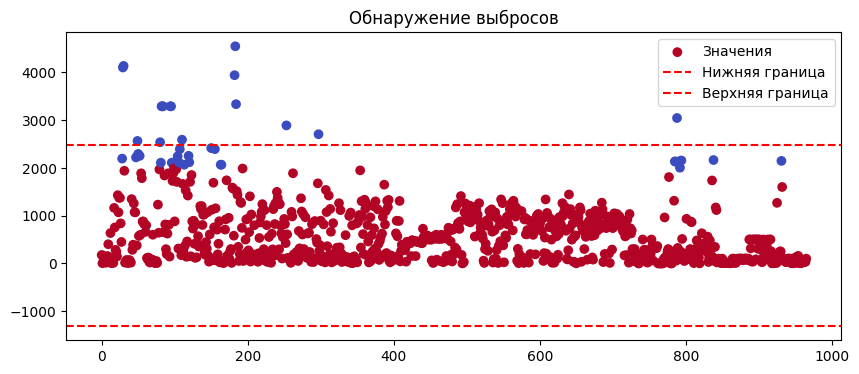

In [ ]:
mean = data['CC50'].mean()
std = data['CC50'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

data["outlier"] = (data['CC50'] < lower_bound) | (data['CC50'] > 2000)
plt.figure(figsize=(10, 4))
plt.scatter(data.index, data['CC50'], c=~data['outlier'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница')
plt.legend()
plt.title('Обнаружение выбросов')
plt.show()

In [ ]:
data['outlier_3'] = (data['CC50'] < lower_bound) | (data['CC50'] > 2000)
data_cleaned = data[~data['outlier_3']].drop(columns=['outlier', 'outlier_3'])

# Отбор признаков различными алгоритмами

In [ ]:
def correlation_feature_selections(df, target_col, threshold=0.15):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [ ]:
selected_features_by_corr = correlation_feature_selections(data_cleaned, target_col='CC50')

Выбранные признаки (14): ['FpDensityMorgan1', 'VSA_EState4', 'MolWt', 'fr_NH2', 'PEOE_VSA7', 'fr_ketone', 'fr_allylic_oxid', 'SlogP_VSA3', 'qed', 'PEOE_VSA6', 'NumSaturatedHeterocycles', 'EState_VSA2', 'SMR_VSA10', 'SlogP_VSA1']


In [ ]:
def random_forest_feature_selection(df, target_col, n_top=20):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-10 важных признаков:
 ['FpDensityMorgan1', 'BCUT2D_MRLOW', 'MolLogP', 'MolWt', 'SPS', 'BCUT2D_MWLOW', 'Ipc', 'PEOE_VSA7', 'VSA_EState4', 'BalabanJ']


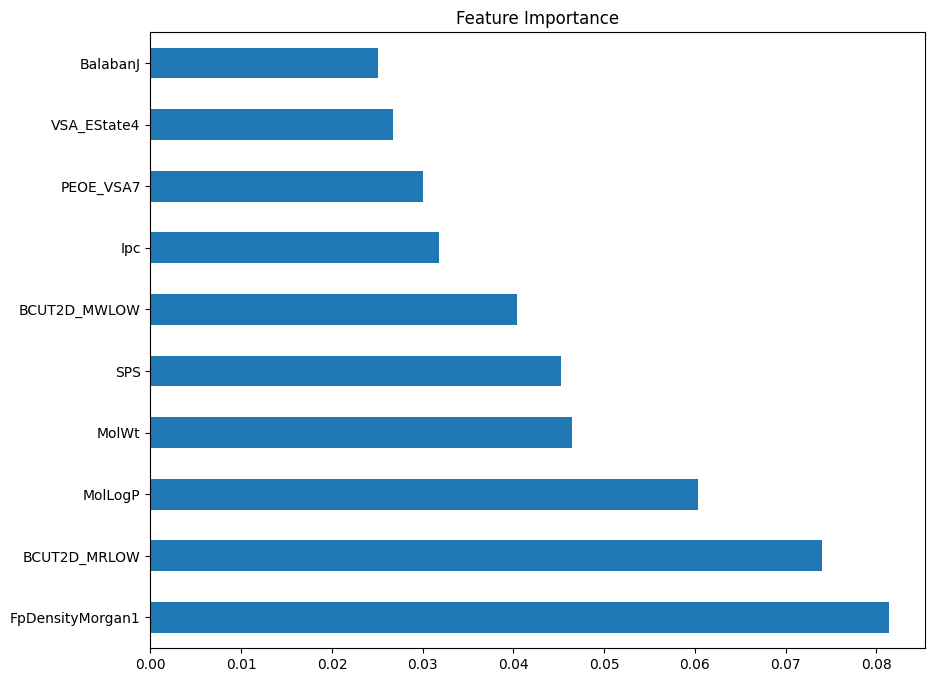

In [ ]:
selected_features_by_rand_for = random_forest_feature_selection(data_cleaned, target_col='CC50', n_top=10)

In [ ]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [ ]:
selected_features_by_lasso = lasso_feature_selection(data_cleaned, target_col='CC50')

Коэффициенты:
FpDensityMorgan1            33.594354
NumSaturatedHeterocycles    24.955382
fr_Imine                    23.906844
fr_quatN                    16.110507
fr_Ndealkylation1           14.181965
                              ...    
PEOE_VSA6                  -19.625878
fr_allylic_oxid            -27.084010
PEOE_VSA7                  -31.482422
MolWt                      -51.509646
fr_NH2                     -76.992372
Length: 94, dtype: float64
Оставлено признаков: 16
Оставленные признаки: ['MolWt', 'FpDensityMorgan1', 'BCUT2D_MRLOW', 'PEOE_VSA6', 'PEOE_VSA7', 'EState_VSA4', 'NumSaturatedHeterocycles', 'fr_Ar_OH', 'fr_C_S', 'fr_Imine', 'fr_NH2', 'fr_Ndealkylation1', 'fr_allylic_oxid', 'fr_ketone', 'fr_quatN', 'fr_sulfide']


# Подбор модели и гиперпараметров с предсказанием по наилучшим параметрам

In [ ]:
def get_models():
  models = {
      "Linear Regression": {
          "model": LinearRegression(),
          "params": {}
      },
      "Random Forest": {
          "model": RandomForestRegressor(random_state=42),
          "params": {
              'n_estimators': [20, 50, 100],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 3, 5, 10]
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingRegressor(random_state=42),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      "XGBoost": {
          "model": XGBRegressor(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      'CatBoost':{
          "model":  CatBoostRegressor(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 8],
              'l2_leaf_reg': [1, 5, 7]
          }
      }
  }
  return models

In [ ]:
def get_regression(X_train, y_train, X_test, y_test):
  results = []
  models = get_models()
  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # пропускаем пустые параметры (например, у LinearRegression)
          model = config['model']
          model.fit(X_train, y_train)
          best_params = {}
      else:
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
          grid.fit(X_train, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказание
      y_pred = model.predict(X_test)

      # Метрики
      mae = mean_absolute_error(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "MAE": mae,
          "RMSE": rmse,
          "R²": r2
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
  return results

In [ ]:
X = data_cleaned[selected_features_by_corr]
y = data_cleaned['CC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res1 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 352.3964, RMSE: 426.4211, R²: 0.2138

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 297.6439, RMSE: 371.4864, R²: 0.4033

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 296.0416, RMSE: 376.6616, R²: 0.3866

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 331.4436, RMSE: 401.6242, R²: 0.3026

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
MAE: 274.5404, RMSE: 358.6152, R²: 0.4439


In [ ]:
X = data_cleaned[selected_features_by_lasso]
y = data_cleaned['CC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res2 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 320.0071, RMSE: 389.1207, R²: 0.3453

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
MAE: 281.6873, RMSE: 354.7753, R²: 0.4558

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
MAE: 266.2497, RMSE: 338.6413, R²: 0.5041

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
MAE: 324.3596, RMSE: 391.6811, R²: 0.3367

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
MAE: 263.1106, RMSE: 328.3340, R²: 0.5339


In [ ]:
X = data_cleaned[selected_features_by_rand_for]
y = data_cleaned['CC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res3 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 382.0124, RMSE: 442.9979, R²: 0.1515

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}
MAE: 310.0893, RMSE: 387.4545, R²: 0.3509

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 313.2698, RMSE: 382.5921, R²: 0.3671

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 330.8017, RMSE: 406.0353, R²: 0.2871

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.05}
MAE: 315.8574, RMSE: 393.7692, R²: 0.3296


Если оценивать в общем модель регрессии, то лучше всех справился CatBoost на данных, признаки которых были отобраны с помощью Lasso, при параметрах:  {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1} и метриках: MAE: 263.1106, RMSE: 328.3340, R²: 0.5339.